In [1]:
import sys
sys.path.append("..")
import torch
from diffusers import UNet2DModel, DDIMScheduler, DDPMPipeline
import matplotlib.pyplot as plt
from fixer.models import *
from fixer.vision_repair import *
from datasets import *
from ad import *
torch.cuda.set_device(1)


/home/antonxue/lib/miniconda3/envs/arpro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def create_star_mask(dimensions, center, size):
    """
    Create a mask for a simple five-point star shape.
    
    :param dimensions: Tuple of (height, width) for the mask dimensions.
    :param center: Tuple of (x, y) for the center of the star.
    :param size: Integer, specifying the overall size of the star.
    :return: A mask tensor with the same dimensions, star is 1, background is 0.
    """
    mask = torch.zeros(dimensions)
    cx, cy = center
    # Define points of the star (simple approximation)
    points = [
        (cx, cy - size),  # Top point
        (cx + size / 3, cy - size / 3),
        (cx + size, cy - size / 3),  # Right point
        (cx + size / 2, cy + size / 6),
        (cx + size / 3, cy + size),  # Bottom right point
        (cx - size / 3, cy + size),
        (cx - size / 2, cy + size / 6),
        (cx - size, cy - size / 3),  # Left point
        (cx - size / 3, cy - size / 3),
    ]
    # Draw lines between points using Bresenham's line algorithm
    for i in range(len(points)):
        x0, y0 = points[i]
        x1, y1 = points[(i + 1) % len(points)]
        for x, y in bresenham_line(x0, y0, x1, y1):
            mask[int(y), int(x)] = 1
    return mask

def bresenham_line(x0, y0, x1, y1):
    """Generate integer coordinates on the line from (x0, y0) to (x1, y1) using Bresenham's algorithm."""
    x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)
    dx = abs(x1 - x0)
    dy = -abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx + dy
    while True:
        yield x0, y0
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 >= dy:
            err += dy
            x0 += sx
        if e2 <= dx:
            err += dx
            y0 += sy



In [ ]:
def add_star(images):
    # Image and star parameters
    image_dimensions = (256, 256)  # Image size
    star_center = (100, 100)  # Center of the star
    star_size = 10  # Size of the star
    image = batch["image"][3]
    # Create an image tensor (3 channels, black image)
    # image = torch.zeros((3,) + image_dimensions)

    # Create a star mask
    star_mask = create_star_mask(image_dimensions, star_center, star_size)

    for image in images:
        # Apply the star mask to the image tensor on all channels
        for c in range(3):  # Assuming RGB channels
            image[c] = image[c] + star_mask  # Adding the star mask to each channel

        # Visualize the result using matplotlib
        plt.imshow(image.permute(1, 2, 0))
        plt.show()
    return images

## pcb4

In [2]:
model_path = "../_dump/fixer_diffusion_visa_pcb4_best.pt"
model_dict = torch.load(model_path)['model_state_dict']
mydiff = MyDiffusionModel(image_size=512)
mydiff.load_state_dict(model_dict)
mydiff.eval().cuda();

ad = FastflowAdModel(image_size=512)
state_dict = torch.load(f"../_dump/ad_noisy_fast_wide_resnet50_2_visa_pcb4_512_best.pt")["model_state_dict"]
ad.load_state_dict(state_dict)
ad.eval().cuda();

In [3]:
torch.manual_seed(1234)
dataloader = get_fixer_dataloader("visa", batch_size=8, category="pcb4", split="test", image_size=512)
for batch in dataloader:
    break
print(batch["label"])

tensor([0, 1, 1, 1, 0, 1, 1, 0])


In [ ]:
plt.clf()
fig, ax = plt.subplots(1,3)

ax[0].imshow(batch["image"][1].numpy().transpose(1,2,0))
ax[1].imshow(batch["image"][2].numpy().transpose(1,2,0))
ax[2].imshow(batch["image"][3].numpy().transpose(1,2,0))

In [ ]:
plt.clf()
fig, ax = plt.subplots(1,3)

ax[0].imshow(batch["mask"][1].numpy().transpose(1,2,0))
ax[1].imshow(batch["mask"][2].numpy().transpose(1,2,0))
ax[2].imshow(batch["mask"][3].numpy().transpose(1,2,0))

In [4]:
x_bad = batch["image"][[2,3]].cuda()
ad_out = ad(2*x_bad-1)


In [ ]:
plt.clf()
fig, ax = plt.subplots(1,2)

ax[0].imshow(ad_out.alpha[0].cpu().detach().numpy().transpose(1,2,0))
ax[1].imshow(ad_out.alpha[1].cpu().detach().numpy().transpose(1,2,0))
# ax[2].imshow(batch["mask"][3].numpy().transpose(1,2,0))

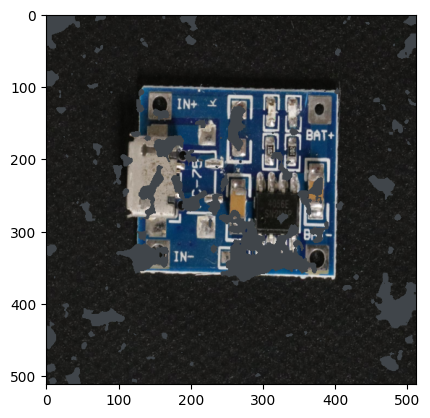

In [5]:
# anom_parts = batch["mask"][[3,7]]
anom_parts = (ad_out.alpha > ad_out.alpha.view(x_bad.size(0),-1).quantile(0.9,dim=1).view(-1,1,1,1)).long()
average_colors = (x_bad * anom_parts).sum(dim=(-1,-2)) / (anom_parts.sum(dim=(-1,-2)))
x_bad_masked = (1-anom_parts) * x_bad + anom_parts * (average_colors.view(-1,3,1,1))
plt.imshow(x_bad_masked[0].cpu().permute(1, 2, 0))

In [6]:
noise_level = 900
out = mydiff(x_bad_masked.cuda(), noise_level, num_inference_steps=1000, progress_bar=True)
# out = (out+1) * 0.5

100%|██████████| 1000/1000 [03:54<00:00,  4.26it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

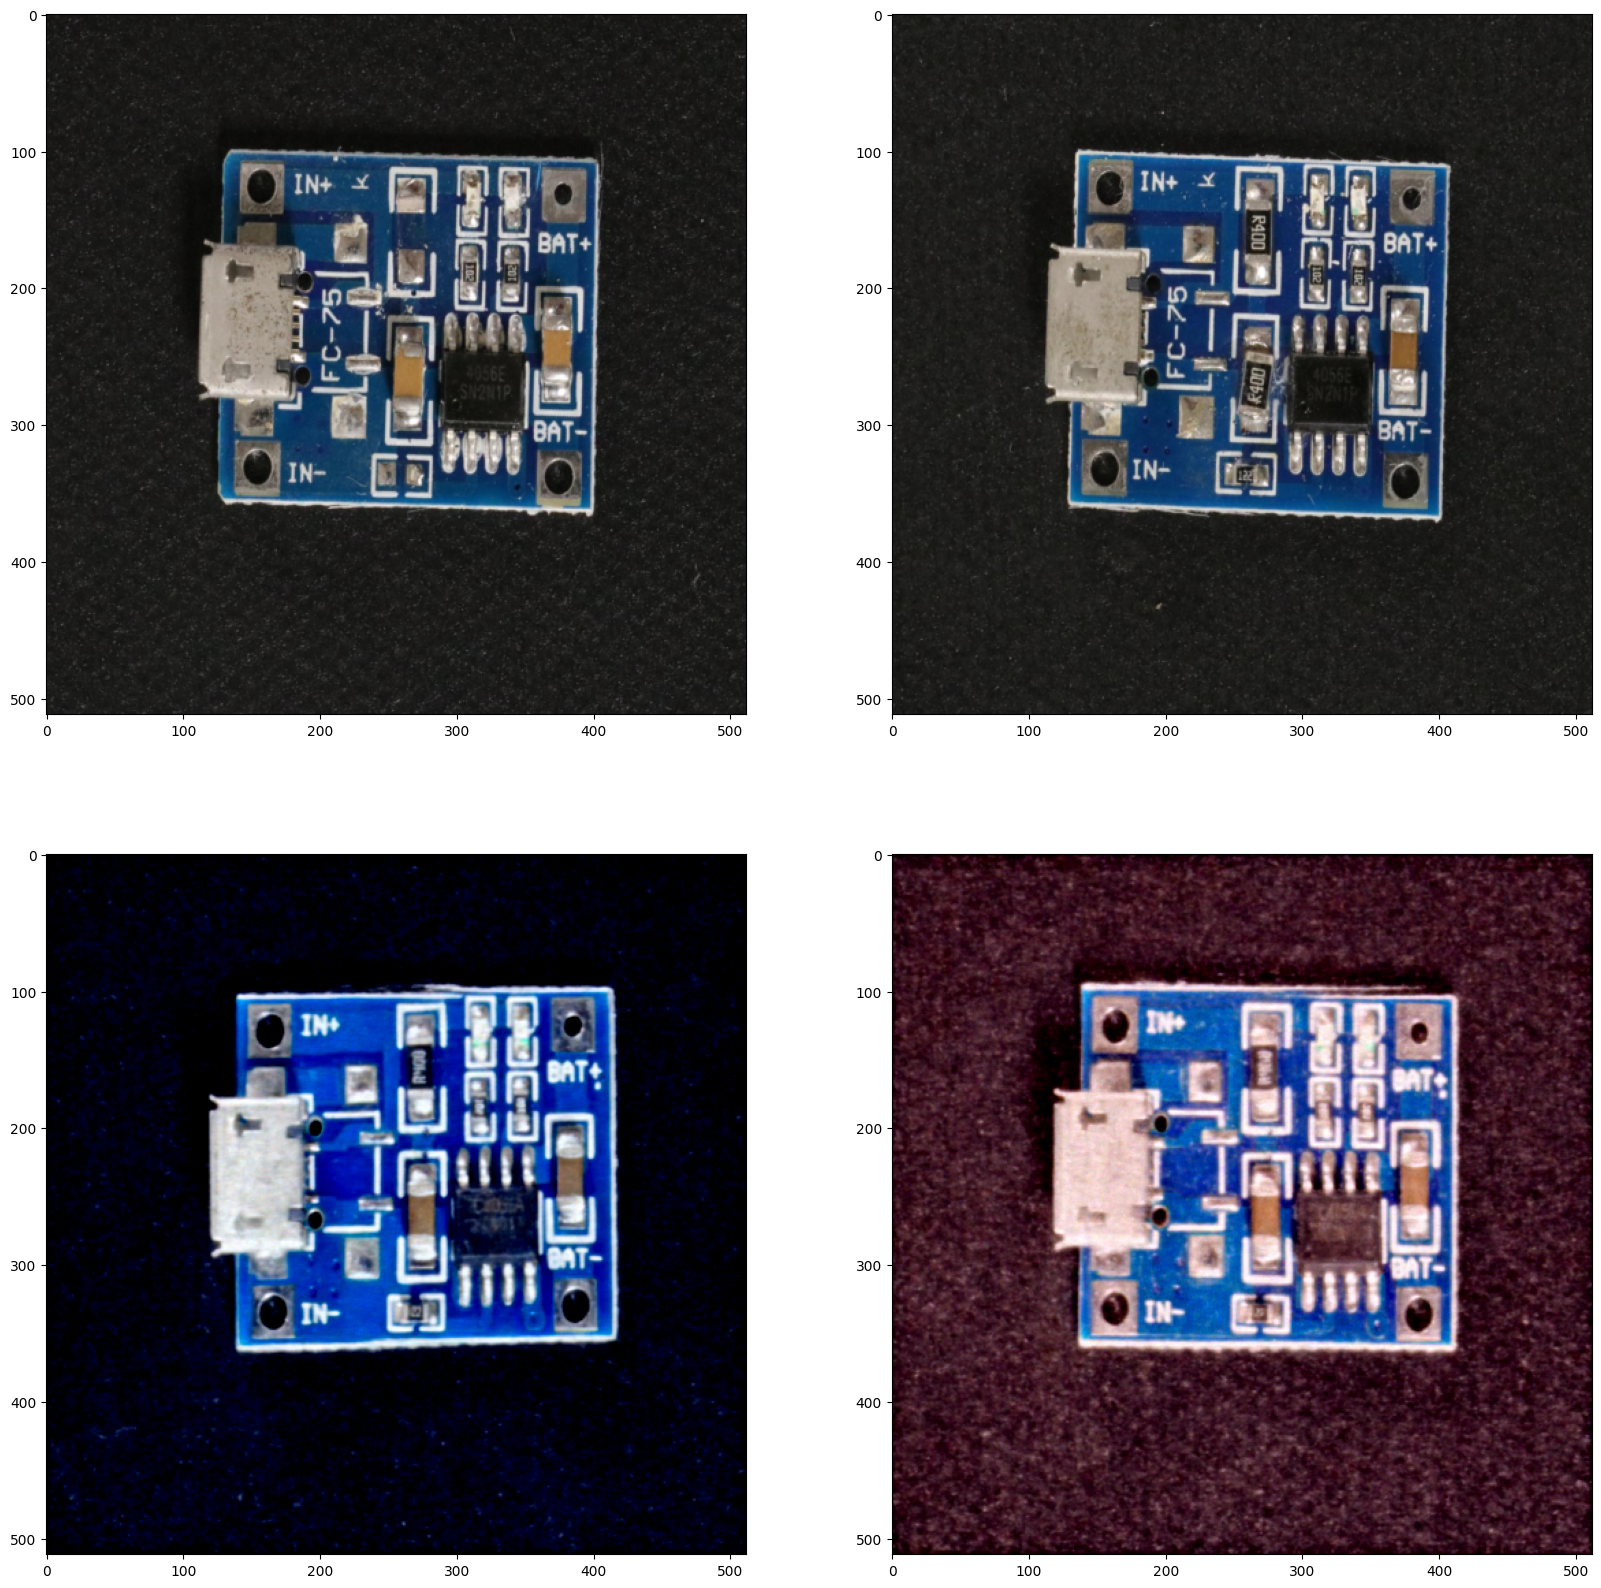

In [7]:
x_bad = x_bad.cpu()
out = out.cpu()
plt.clf()
fig, ax = plt.subplots(2,2, figsize=(20, 20))
ax[0,0].imshow(x_bad[0].numpy().transpose(1,2,0))
ax[0,1].imshow(x_bad[1].numpy().transpose(1,2,0))
ax[1,0].imshow(out[0].cpu().numpy().transpose(1,2,0))
ax[1,1].imshow(out[1].cpu().numpy().transpose(1,2,0))

In [ ]:
noise_level = 900
x_bad = x_bad.cuda()
config = VisionRepairConfig(category="pcb4", lr=1e-5, batch_size=2, guide_scale_end=0.1, prop1_scale=10.)
out = vision_repair(x_bad, anom_parts, ad, mydiff, config, noise_level)
# out = (out + 1) * 0.5


In [ ]:
x_fix = out['x_fix']
x_fix_ad_out = ad(x_fix)
prop1_loss = torch.norm(x_fix_ad_out.score.mean(), p=2)
print(prop1_loss)
# x_fix = out['x_fix'] *0.5 + 0.5
x_fix = x_fix.clamp(0,1).detach().cpu()
x_bad = x_bad.cpu()
x_merge = (1-anom_parts.cpu()).long()*x_bad + anom_parts.cpu() * x_fix
plt.clf()
fig, ax = plt.subplots(3,2, figsize=(4, 8))
ax[0,0].imshow(x_bad[0].numpy().transpose(1,2,0))
ax[0,1].imshow(x_bad[1].numpy().transpose(1,2,0))
ax[1,0].imshow(x_fix[0].cpu().numpy().transpose(1,2,0))
ax[1,1].imshow(x_fix[1].cpu().numpy().transpose(1,2,0))
ax[2,0].imshow(x_bad_masked[0].cpu().numpy().transpose(1,2,0))
ax[2,1].imshow(x_bad_masked[1].cpu().numpy().transpose(1,2,0))
# ax[3,0].imshow(x_merge[0].cpu().numpy().transpose(1,2,0))
# ax[3,1].imshow(x_merge[1].cpu().numpy().transpose(1,2,0))

In [ ]:
x_fix = x_fix.detach()

In [ ]:
noise_level = 900
x_bad = x_bad.cuda()

config = VisionRepairConfig(category="pcb4", lr=1e-5, batch_size=2, guide_scale_end=0.1, prop1_scale=1.)
out = vision_repair(x_bad, anom_parts, ad, mydiff, config, noise_level)
# out = (out + 1) * 0.5


In [ ]:
x_fix = out['x_fix']
x_fix_ad_out = ad(x_fix)
prop1_loss = torch.norm(x_fix_ad_out.score.mean(), p=2)
print(prop1_loss)
# x_fix = out['x_fix'] *0.5 + 0.5
x_fix = x_fix.clamp(0,1).detach().cpu()
x_bad = x_bad.cpu()
x_merge = (1-anom_parts.cpu()).long()*x_bad + anom_parts.cpu() * x_fix
plt.clf()
fig, ax = plt.subplots(3,2, figsize=(4, 8))
ax[0,0].imshow(x_bad[0].numpy().transpose(1,2,0))
ax[0,1].imshow(x_bad[1].numpy().transpose(1,2,0))
ax[1,0].imshow(x_fix[0].cpu().numpy().transpose(1,2,0))
ax[1,1].imshow(x_fix[1].cpu().numpy().transpose(1,2,0))
ax[2,0].imshow(x_bad_masked[0].cpu().numpy().transpose(1,2,0))
ax[2,1].imshow(x_bad_masked[1].cpu().numpy().transpose(1,2,0))
# ax[3,0].imshow(x_merge[0].cpu().numpy().transpose(1,2,0))
# ax[3,1].imshow(x_merge[1].cpu().numpy().transpose(1,2,0))

In [ ]:
noise_level = 900
x_bad = x_bad.cuda()

config = VisionRepairConfig(category="pcb4", lr=1e-5, batch_size=2, guide_scale_end=0.1, prop1_scale=1.)
out = vision_repair(x_bad, anom_parts, ad, mydiff, config, noise_level)
# out = (out + 1) * 0.5


In [ ]:
plt.clf()
fig, ax = plt.subplots(2,2, figsize=(20, 20))
ax[0,0].imshow(x_bad[0].numpy().transpose(1,2,0))
ax[0,1].imshow(x_bad[1].numpy().transpose(1,2,0))
ax[1,0].imshow(x_fix[0].cpu().numpy().transpose(1,2,0))
ax[1,1].imshow(x_fix[1].cpu().numpy().transpose(1,2,0))
# ax[2,0].imshow(x_bad_masked[0].cpu().numpy().transpose(1,2,0))
# ax[2,1].imshow(x_bad_masked[1].cpu().numpy().transpose(1,2,0))

## pcb2

In [ ]:
model_path = "../_dump/fixer_diffusion_visa_pcb2_best.pt"
model_dict = torch.load(model_path)['model_state_dict']
mydiff = MyDiffusionModel()
mydiff.load_state_dict(model_dict)
mydiff.eval().cuda();

ad = FastflowAdModel()
state_dict = torch.load(f"../_dump/ad_noisy_fast_visa_pcb2_best.pt")["model_state_dict"]
ad.load_state_dict(state_dict)
ad.eval().cuda();

In [ ]:
torch.manual_seed(1234)
dataloader = get_fixer_dataloader("visa", batch_size=8, category="pcb2", split="test")
for batch in dataloader:
    break
print(batch["label"])

In [ ]:
plt.clf()
fig, ax = plt.subplots(1,3)

ax[0].imshow(batch["image"][0].numpy().transpose(1,2,0))
ax[1].imshow(batch["image"][3].numpy().transpose(1,2,0))
ax[2].imshow(batch["image"][7].numpy().transpose(1,2,0))

In [ ]:
x_bad = batch["image"][[3,7]].cuda()
ad_out = ad(x_bad)


In [ ]:
# anom_parts = batch["mask"][[3,7]]
anom_parts = (ad_out.alpha > ad_out.alpha.view(x_bad.size(0),-1).quantile(0.3,dim=1).view(-1,1,1,1)).long()
average_colors = (x_bad * anom_parts).sum(dim=(-1,-2)) / (anom_parts.sum(dim=(-1,-2)))
x_bad_masked = (1-anom_parts) * x_bad + anom_parts * (average_colors.view(-1,3,1,1))
plt.imshow(x_bad_masked[0].cpu().permute(1, 2, 0))

### no property guide

In [ ]:
noise_level = 900
out = mydiff(x_bad_masked.cuda(), noise_level, num_inference_steps=1000, progress_bar=True)
out = (out+1) * 0.5

In [ ]:
x_bad = x_bad.cpu()
out = out.clamp(0,1).cpu()
plt.clf()
fig, ax = plt.subplots(2,2, figsize=(20, 20))
ax[0,0].imshow(x_bad[0].numpy().transpose(1,2,0))
ax[0,1].imshow(x_bad[1].numpy().transpose(1,2,0))
ax[1,0].imshow(out[0].cpu().numpy().transpose(1,2,0))
ax[1,1].imshow(out[1].cpu().numpy().transpose(1,2,0))

### property guide

In [ ]:
noise_level = 600
x_bad = x_bad.cuda()
config = VisionRepairConfig(category="pcb2", lr=1e-5, batch_size=2, guide_scale_end=0.1, prop2_scale=10.)
out = vision_repair(x_bad, anom_parts, ad, mydiff, config, noise_level)
# out = (out + 1) * 0.5

In [ ]:
x_fix = out['x_fix']
# x_fix = out['x_fix'] *0.5 + 0.5
x_fix = x_fix.clamp(0,1).detach().cpu()
x_bad = x_bad.cpu()
x_merge = (1-anom_parts.cpu()).long()*x_bad + anom_parts.cpu() * x_fix
plt.clf()
fig, ax = plt.subplots(3,2, figsize=(4, 8))
ax[0,0].imshow(x_bad[0].numpy().transpose(1,2,0))
ax[0,1].imshow(x_bad[1].numpy().transpose(1,2,0))
ax[1,0].imshow(x_fix[0].cpu().numpy().transpose(1,2,0))
ax[1,1].imshow(x_fix[1].cpu().numpy().transpose(1,2,0))
ax[2,0].imshow(x_bad_masked[0].cpu().numpy().transpose(1,2,0))
ax[2,1].imshow(x_bad_masked[1].cpu().numpy().transpose(1,2,0))
# ax[3,0].imshow(x_merge[0].cpu().numpy().transpose(1,2,0))
# ax[3,1].imshow(x_merge[1].cpu().numpy().transpose(1,2,0))

## transistor

In [ ]:
model_path = "../_dump/fixer_diffusion_mvtec_transistor_best.pt"
model_dict = torch.load(model_path)['model_state_dict']
mydiff = MyDiffusionModel()
mydiff.load_state_dict(model_dict)
mydiff.eval().cuda();

ad = FastflowAdModel()
state_dict = torch.load(f"../_dump/ad_fast_mvtec_transistor_best.pt")["model_state_dict"]
ad.load_state_dict(state_dict)
ad.eval().cuda();

In [ ]:
torch.manual_seed(1234)
dataloader = get_fixer_dataloader("mvtec", batch_size=8, category="transistor", split="test")
for batch in dataloader:
    break
print(batch["label"])

In [ ]:
plt.clf()
fig, ax = plt.subplots(1,3)

ax[0].imshow(batch["image"][0].numpy().transpose(1,2,0))
ax[1].imshow(batch["image"][3].numpy().transpose(1,2,0))
ax[2].imshow(batch["image"][7].numpy().transpose(1,2,0))

In [ ]:
batch["image"][[3,7]].shape

In [ ]:
ad_out = ad(batch["image"][[3,7]].cuda())
x_bad = add_star(batch["image"][[3,7]]).cuda()

In [ ]:
# anom_parts = batch["mask"][[3,7]]
anom_parts = (ad_out.alpha > ad_out.alpha.view(x_bad.size(0),-1).quantile(0.90,dim=1).view(-1,1,1,1)).long()
average_colors = (x_bad * anom_parts).sum(dim=(-1,-2)) / (anom_parts.sum(dim=(-1,-2)))
x_bad_masked = (1-anom_parts) * x_bad + anom_parts * (average_colors.view(-1,3,1,1))
plt.imshow(x_bad_masked[1].cpu().permute(1, 2, 0))

In [ ]:
noise_level = 999
x_bad = x_bad.cuda()
config = VisionRepairConfig(mvtec_category="transistor", lr=1e-5, batch_size=2, guide_scale_end=0.1, prop2_scale=10.)
out = vision_repair(x_bad, anom_parts, ad, mydiff, config, noise_level)
# out = (out + 1) * 0.5

In [ ]:
x_fix = out['x_fix']
# x_fix = out['x_fix'] *0.5 + 0.5
x_fix = x_fix.clamp(0,1).detach().cpu()
x_bad = x_bad.cpu()
x_merge = (1-anom_parts.cpu()).long()*x_bad + anom_parts.cpu() * x_fix
plt.clf()
fig, ax = plt.subplots(3,2, figsize=(4, 8))
ax[0,0].imshow(x_bad[0].numpy().transpose(1,2,0))
ax[0,1].imshow(x_bad[1].numpy().transpose(1,2,0))
ax[1,0].imshow(x_fix[0].cpu().numpy().transpose(1,2,0))
ax[1,1].imshow(x_fix[1].cpu().numpy().transpose(1,2,0))
ax[2,0].imshow(x_bad_masked[0].cpu().numpy().transpose(1,2,0))
ax[2,1].imshow(x_bad_masked[1].cpu().numpy().transpose(1,2,0))
# ax[3,0].imshow(x_merge[0].cpu().numpy().transpose(1,2,0))
# ax[3,1].imshow(x_merge[1].cpu().numpy().transpose(1,2,0))

In [ ]:
breakpoint()

In [ ]:
noise_level = 900

In [ ]:

out = mydiff(x_bad_masked.cuda(), noise_level, num_inference_steps=1000, progress_bar=True)
out = (out+1) * 0.5

In [ ]:
x_bad = x_bad.cpu()
out = out.clamp(0,1).cpu()
plt.clf()
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(x_bad[0].numpy().transpose(1,2,0))
ax[0,1].imshow(x_bad[1].numpy().transpose(1,2,0))
ax[1,0].imshow(out[0].cpu().numpy().transpose(1,2,0))
ax[1,1].imshow(out[1].cpu().numpy().transpose(1,2,0))

In [ ]:
out

In [ ]:
merge_images = (anom_parts.cpu() * out + x_bad * (1-anom_parts.cpu())).detach()
plt.clf()
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(x_bad[0].numpy().transpose(1,2,0))
ax[0,1].imshow(x_bad[1].numpy().transpose(1,2,0))
ax[1,0].imshow(merge_images[0].cpu().numpy().transpose(1,2,0))
ax[1,1].imshow(merge_images[1].cpu().numpy().transpose(1,2,0))

In [ ]:
noise_level = 1000
config = VisionRepairConfig(mvtec_category="transistor", lr=1e-5, batch_size=2, guide_scale=0.01)
images = vision_repair(x_bad, ad, mydiff, config, noise_level)

In [ ]:
config = VisionRepairConfig(mvtec_category="transistor", lr=1e-5, batch_size=2, guide_scale=0.001)
images = vision_repair(x_bad, ad, mydiff, config, noise_level)

In [ ]:
config = VisionRepairConfig(mvtec_category="transistor", lr=1e-5, batch_size=2, guide_scale=0.0001)
images = vision_repair(x_bad, ad, mydiff, config, noise_level)

In [ ]:
config = VisionRepairConfig(mvtec_category="transistor", lr=1e-5, batch_size=2, guide_scale=1e-5)
images = vision_repair(x_bad, ad, mydiff, config, noise_level)

In [ ]:
config = VisionRepairConfig(mvtec_category="transistor", lr=1e-5, batch_size=2, guide_scale=1e-6)
images = vision_repair(x_bad, ad, mydiff, config, noise_level)

In [ ]:
config = VisionRepairConfig(mvtec_category="transistor", lr=1e-5, batch_size=2, guide_scale=0)
images = vision_repair(x_bad, ad, mydiff, config, noise_level)

In [ ]:
noise_level = 900
x_bad = x_bad.cuda()
config = VisionRepairConfig(mvtec_category="transistor", lr=1e-5, batch_size=2, guide_scale=0.00)
images = vision_repair(x_bad, ad, mydiff, config, noise_level)


In [ ]:
x_bad = x_bad.cpu()
out = out.clamp(0,1).cpu()
plt.clf()
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(x_bad[0].numpy().transpose(1,2,0))
ax[0,1].imshow(x_bad[1].numpy().transpose(1,2,0))
ax[1,0].imshow(out[0].cpu().numpy().transpose(1,2,0))
ax[1,1].imshow(out[1].cpu().numpy().transpose(1,2,0))

In [ ]:
plt.clf()
plt.imshow(x_bad_masked[1].numpy().transpose(1,2,0))

In [ ]:
anom_parts.shape

In [ ]:
plt.clf()
plt.imshow(x_bad.mean(dim=))
# plt.imshow(batch["mask"][2].numpy().transpose(1,2,0))

In [ ]:
model_path = "../_dump/fixer_diffusion_mvtec_transistor_best.pt"
model_dict = torch.load(model_path)['model_state_dict']
mydiff = MyDiffusionModel()
mydiff.load_state_dict(model_dict)
mydiff.eval().cuda();

In [ ]:
cat = "transistor"
ad = FastflowAdModel()
state_dict = torch.load(f"../_dump/ad_fast_mvtec_{cat}_best.pt")["model_state_dict"]
ad.load_state_dict(state_dict)
ad.eval().cuda();

In [ ]:
torch.manual_seed(1238)
N = 1
dataloader = get_ad_dataloader("mvtec", batch_size=N, category=cat, split="test", normalize_image=False)
for batch in dataloader:
    x = batch["image"].cuda()
    break
image_numpy = x.cpu().squeeze().permute(1, 2, 0).numpy()

# Plotting the image
plt.figure(figsize=(6, 6))
plt.imshow(image_numpy)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [ ]:
config = VisionRepairConfig(mvtec_category=cat, lr=1e-3, batch_size=N)
repair(ad, mydiff, x, config)

In [ ]:
t = torch.LongTensor([1,2,3,4]).cuda()

In [ ]:
t.device

In [ ]:
x = torch.LongTensor([3])

In [ ]:
x.view(1,1).repeat(10,1)

In [ ]:
with torch.no_grad():
    out = mydiff.unet(torch.rand(7,3,256,256).cuda(), torch.randint(0,2,(2,)).cuda())

In [ ]:
out.sample.shape

In [ ]:
torch.rand